In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [6]:
file = 'pokemon.csv'
df = pd.read_csv(file)
df. isnull().sum()

pokemon_id                        0
pokemon_name                      0
base_attack                       0
base_defense                      0
base_stamina                      0
type                              0
rarity                            0
charged_moves                     0
fast_moves                        0
candy_required                  536
distance                          0
max_cp                            0
attack_probability              103
base_capture_rate               103
base_flee_rate                  103
dodge_probability               103
max_pokemon_action_frequency    103
min_pokemon_action_frequency    103
found_egg                       263
found_evolution                 263
found_wild                      263
found_research                  263
found_raid                      263
found_photobomb                 263
dtype: int64

In [19]:
df.shape

(1007, 24)

In [20]:
df.drop_duplicates(keep='first', inplace=True)

In [7]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pokemon_id                    1007 non-null   int64  
 1   pokemon_name                  1007 non-null   object 
 2   base_attack                   1007 non-null   int64  
 3   base_defense                  1007 non-null   int64  
 4   base_stamina                  1007 non-null   int64  
 5   type                          1007 non-null   object 
 6   rarity                        1007 non-null   object 
 7   charged_moves                 1007 non-null   object 
 8   fast_moves                    1007 non-null   object 
 9   candy_required                471 non-null    float64
 10  distance                      1007 non-null   int64  
 11  max_cp                        1007 non-null   int64  
 12  attack_probability            904 non-null    float64
 13  bas

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from pycaret.classification import *
data = setup(train, target = 'output', normalize=True, test_data=test, session_id = 1999)

In [ ]:
svm = create_model('rbfsvm')
evaluate_model(svm)

In [8]:
# Selezione delle feature e target
features = ["base_attack", "base_defense", "base_stamina", "max_cp", "attack_probability", "base_capture_rate", "base_flee_rate", "dodge_probability", "max_pokemon_action_frequency", "min_pokemon_action_frequency"]
target = "rarity"

# Encoding della variabile target
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

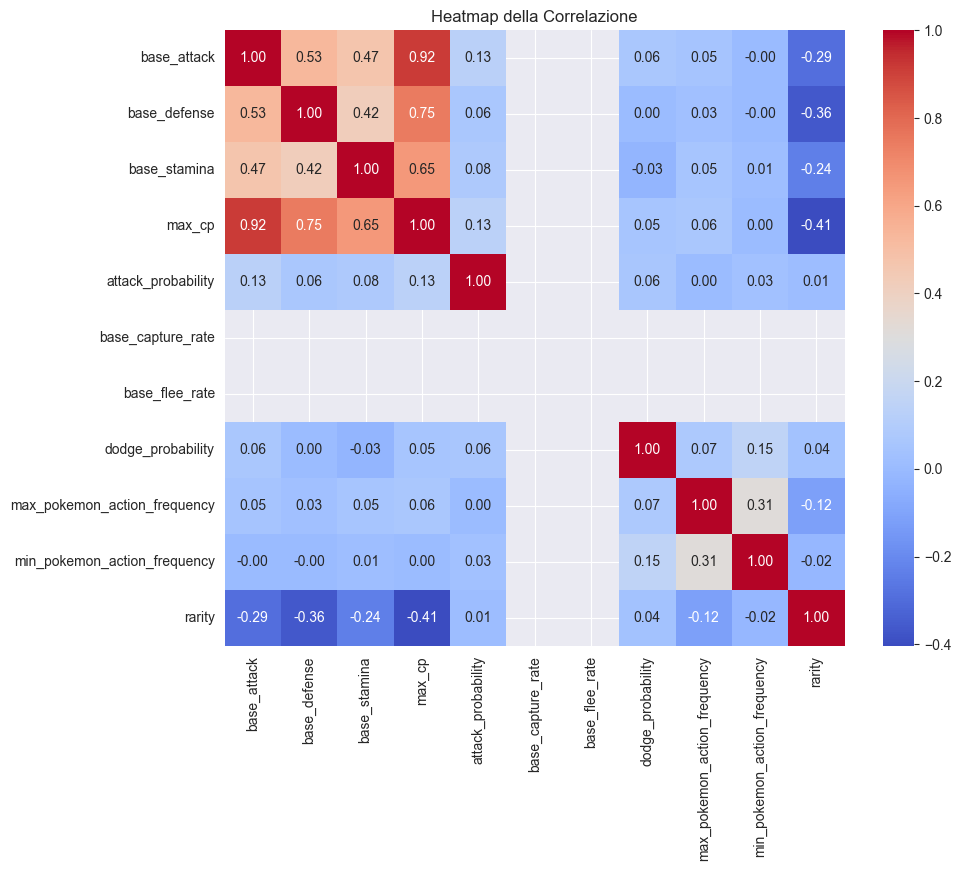

In [9]:
# Heatmap della correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap della Correlazione")
plt.show()

In [10]:
# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Addestramento del modello
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predizione sui dati di test
y_pred = clf.predict(X_test)

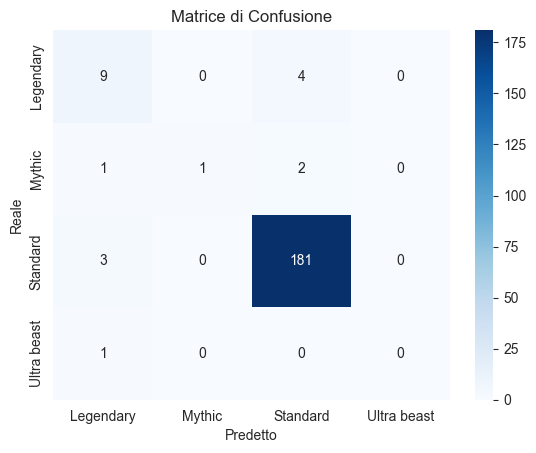

In [12]:
# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione")
plt.show()

In [13]:
# Report di classificazione
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

   Legendary       0.64      0.69      0.67        13
      Mythic       1.00      0.25      0.40         4
    Standard       0.97      0.98      0.98       184
 Ultra beast       0.00      0.00      0.00         1

    accuracy                           0.95       202
   macro avg       0.65      0.48      0.51       202
weighted avg       0.94      0.95      0.94       202



C:\Users\tosca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tosca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tosca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

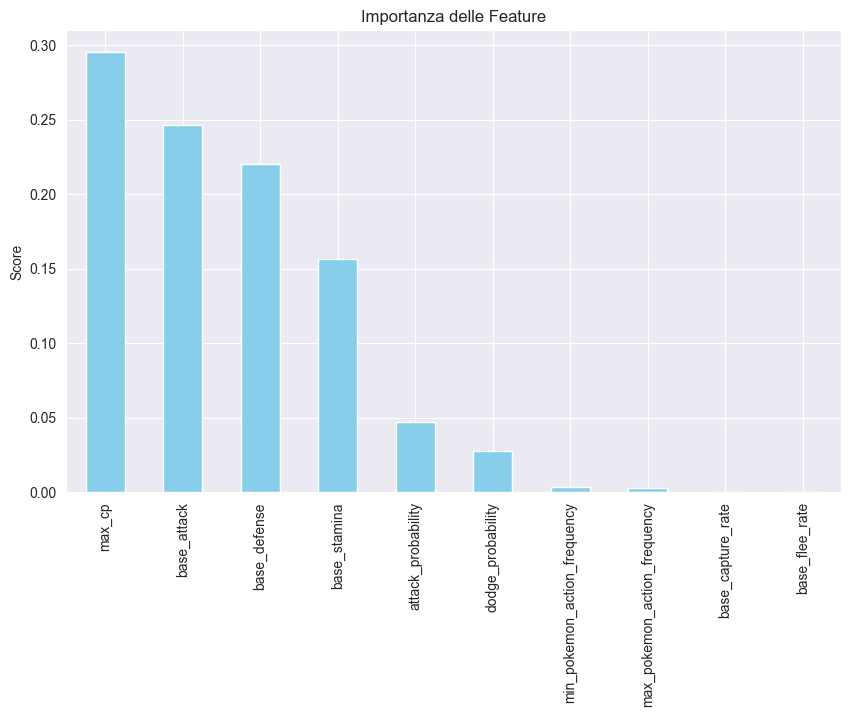

In [14]:
# Grafico dell'importanza delle feature
feature_importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Importanza delle Feature")
plt.ylabel("Score")
plt.show()

In [17]:
# Distribuzione della rarità nei dati
df[target] = label_encoder.inverse_transform(df[target])
sns.countplot(x=df[target], palette="viridis")
plt.title("Distribuzione della Rarità")
plt.xlabel("Rarità")
plt.ylabel("Conteggio")
plt.show()

ValueError: y contains previously unseen labels: ['Legendary' 'Mythic' 'Standard' 'Ultra beast']

In [18]:
# Accuratezza del modello
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza del modello: {accuracy:.2f}")


Accuratezza del modello: 0.95
